In [1]:
import os, tempfile
import logging
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC import plot_sim_results, plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.3
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:289: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:303: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:289: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:303: SyntaxWarning: assertion is always true, perhaps remove parentheses?


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

In [4]:
from experiments.ical_li import (li_act_and_tau,
                                 li_inact_1000,
                                 li_inact_kin_80,
                                 li_recov)

In [5]:
modelfile = 'models/nygren_ical.mmt'

## Plot steady-state and tau functions

In [6]:
from ionchannelABC.visualization import plot_variables

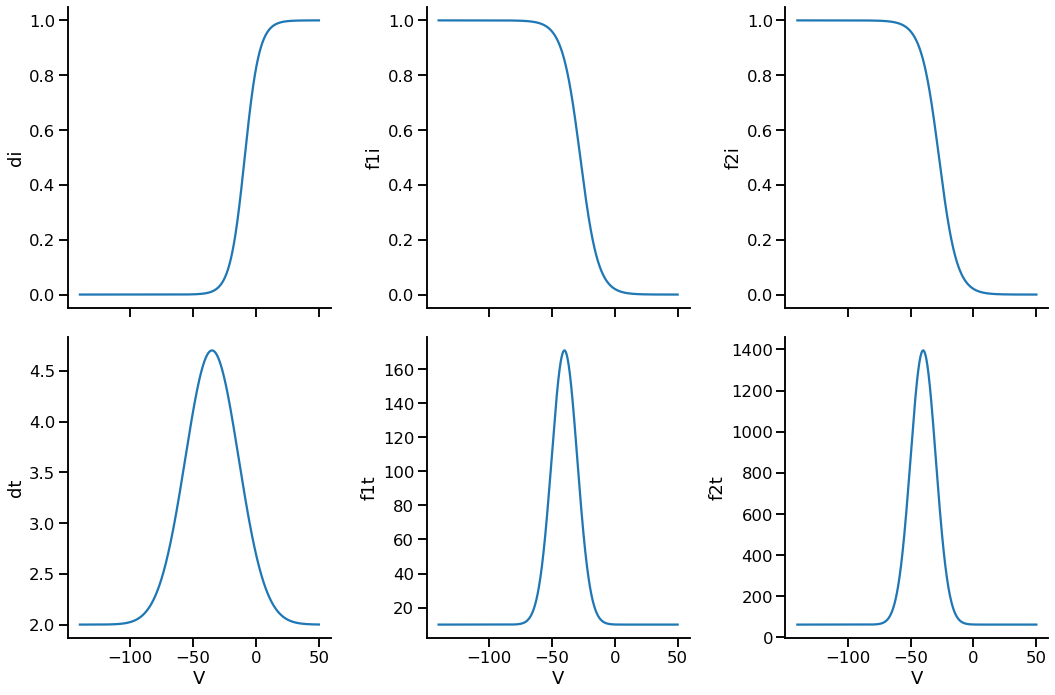

In [7]:
sns.set_context('talk')

V = np.arange(-140, 50, 0.01)

nyg_vars = {'di': 'ical.d_inf',
            'f1i': 'ical.f_inf',
            'f2i': 'ical.f_inf',
            'dt': 'ical.tau_d',
            'f1t': 'ical.tau_f_1',
            'f2t': 'ical.tau_f_2'}

f, ax = plot_variables(V, nyg_vars, 'models/nygren_ical.mmt', figshape=(3,2))

# d gate -> Only activation data

In [8]:
observations, model, summary_statistics = setup(modelfile,
                                                li_act_and_tau)

In [9]:
assert len(observations)==len(summary_statistics(model({})))

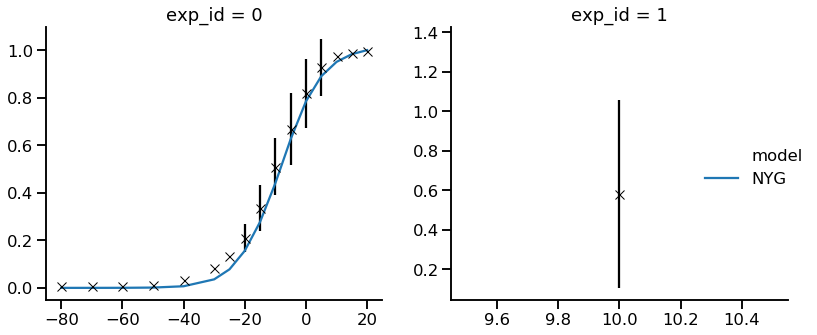

In [10]:
g = plot_sim_results(modelfile,
                     li_act_and_tau)

In [12]:
limits = {'ical.p1': (-100, 100),
          'ical.p2': (0, 50),
          'log_ical.p3': (-7, 3),
          'ical.p4': (-100, 100),
          'ical.p5': (0, 50),
          'log_ical.p6': (-7, 3)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [13]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "nygren_ical_dgate_full.db"))

In [14]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [15]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 64 particles


In [16]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.2287454676498424, '1': 1.2287454676498424, '2': 1.2287454676498424, '3': 1.2287454676498424, '4': 1.2287454676498424, '5': 1.2287454676498424, '6': 1.2287454676498424, '7': 1.0293830767146164, '8': 0.6283247351374927, '9': 0.5133263088125923, '10': 0.4040167399213943, '11': 0.41888315675832816, '12': 0.5146915383573082, '13': 1.2287454676498424, '14': 1.2287454676498424, '15': 1.2287454676498424, '16': 1.2039197677998432}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [17]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [18]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-18 09:52:37.719386, end_time=None)>


In [19]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 3852
DEBUG:Epsilon:new eps, t=1, eps=2.551139210627562
INFO:ABC:t:1 eps:2.551139210627562
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 8011
DEBUG:Epsilon:new eps, t=2, eps=1.5010936714315752
INFO:ABC:t:2 eps:1.5010936714315752
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 12588
DEBUG:Epsilon:new eps, t=3, eps=1.2691794246600032
INFO:ABC:t:3 eps:1.2691794246600032
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 17866
DEBUG:Epsilon:new eps, t=4, eps=1.0801458314591663
INFO:ABC:t:4 eps:1.0801458314591663
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 24716
DEBUG:Epsilon:new eps, t=5, eps=0.85395199300

### Database results analysis

In [20]:
history = History(db_path)

In [21]:
df, w = history.get_distribution(m=0)

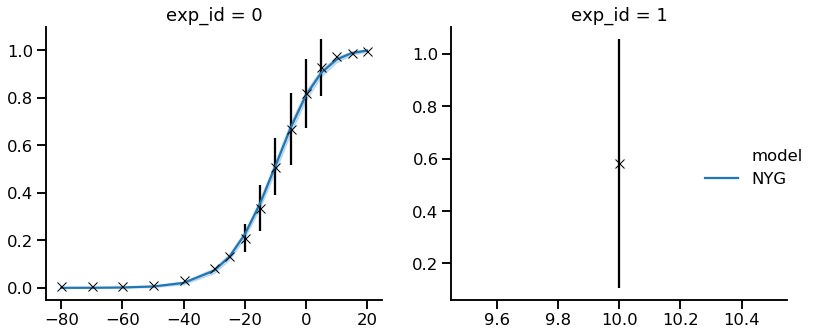

In [22]:
g = plot_sim_results(modelfile,
                     li_act_and_tau,
                     df=df, w=w)

In [23]:
nyg_pars = df.sample(n=100, weights=w, replace=True)
nyg_pars = nyg_pars.set_index([pd.Index(range(100))])
nyg_pars = nyg_pars.to_dict(orient='records')

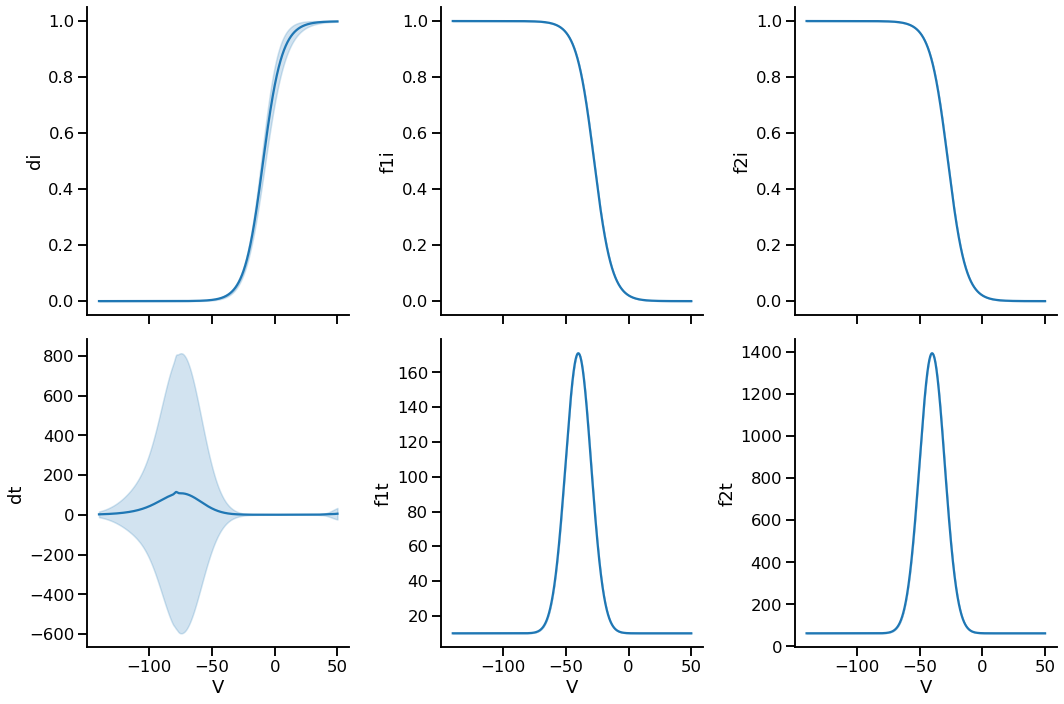

In [24]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, nyg_vars, 
                       'models/nygren_ical.mmt', 
                       [nyg_pars],
                       figshape=(3,2))

In [25]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [26]:
m,_,_ = myokit.load(modelfile)

In [27]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

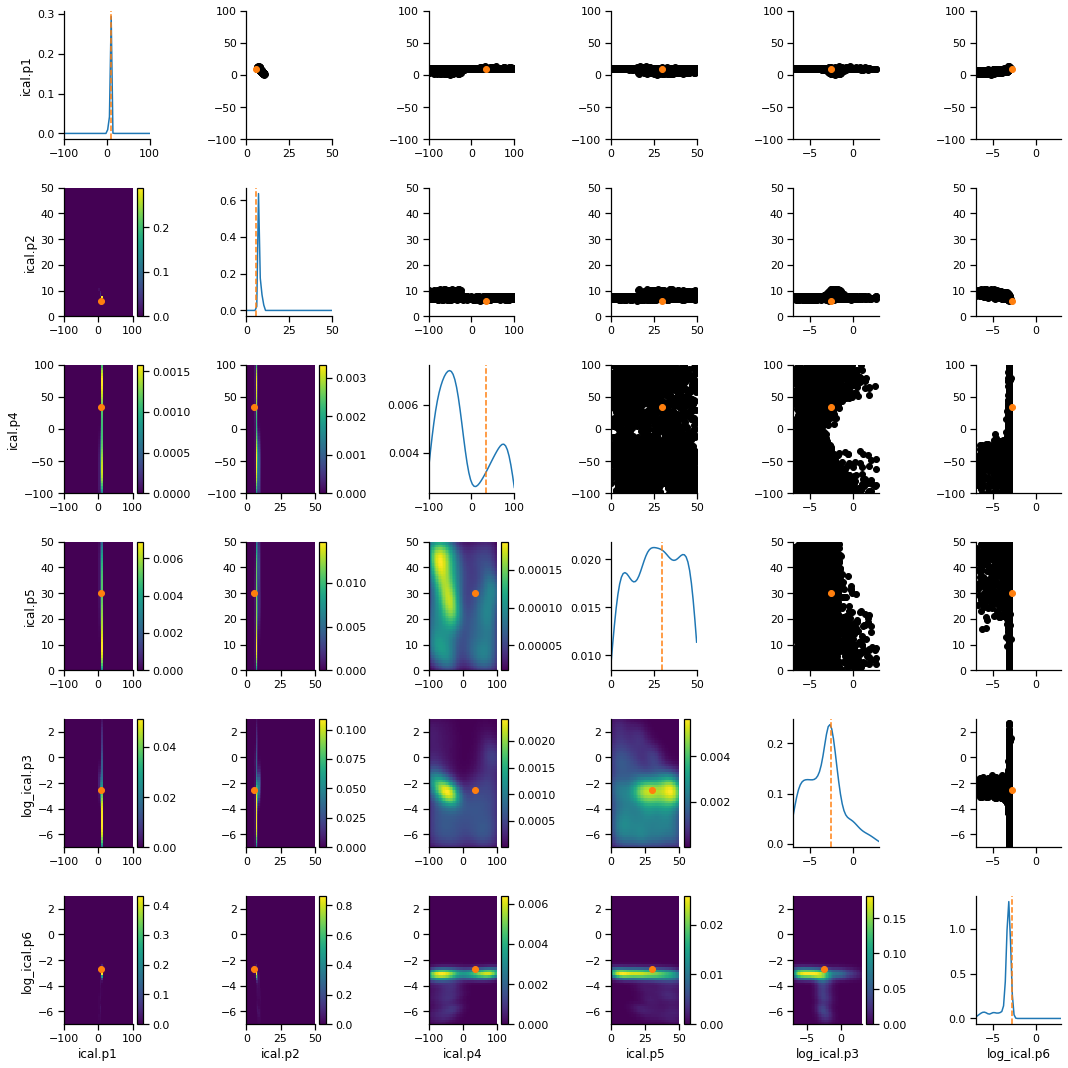

In [28]:
sns.set_context('notebook')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)